# Causal Injection into a Neural Network

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import math
import networkx as nx
import random
import pandas as pd
#import tensorflow as tf
#Disable TensorFlow 2 behaviour
from sklearn.model_selection import KFold , train_test_split
from sklearn.preprocessing import StandardScaler  , MinMaxScaler
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import os
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from CASTLE2 import CASTLE
from utils import gen_random_dag, gen_data_nonlinear, heat_mat, plot_DAG, DAG_retreive_np, save_pickle, load_pickle, random_stability
from signal import signal, SIGINT
from sys import exit
import argparse
import plotly.express as px
from pmlb import fetch_data


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# load dataset and descriptive statistics
dataset_Name = 'adult'; dataset = fetch_data(dataset_Name)

print(dataset.head())    
print(dataset.shape)
print(dataset.columns)

cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

print(dataset[cols].info())    
print(dataset[cols].describe())
print(dataset[cols].corr())    

cols = list(dataset.columns)
cols = [cols[-1]] + cols[:-1]
dataset = dataset[cols]

# load features and target from dataset
X, y = fetch_data(dataset_Name, return_X_y=True)

# Split Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  

# # normalize the dataset i.e. X_train and X_test
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler.fit_transform(X_train)    
# X_test = scaler.fit_transform(X_test)    

    age  workclass    fnlwgt  education  education-num  marital-status  \
0  39.0          7   77516.0          9           13.0               4   
1  50.0          6   83311.0          9           13.0               2   
2  38.0          4  215646.0         11            9.0               0   
3  53.0          4  234721.0          1            7.0               2   
4  28.0          4  338409.0          9           13.0               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           1             1     4    1        2174.0           0.0   
1           4             0     4    1           0.0           0.0   
2           6             1     4    1           0.0           0.0   
3           6             0     2    1           0.0           0.0   
4          10             5     2    0           0.0           0.0   

   hours-per-week  native-country  target  
0            40.0              39       1  
1            13.0              39       1  
2 

## Set parameters

In [11]:
## Parameters Definition
dag_type = 'adult' ##'fico','toy','random'
csv = None
# csv = './data/fico/WOE_Rud_data.csv'
# csv_y = './data/fico/y_data.csv'
# csv = 'synth_nonlinear.csv'
num_nodes = 20
branchf = 4
dataset_sz = 10000
output_log = 'castle_adult.log'
n_folds = 1
reg_lambda = 1
reg_beta = 5
gpu = ''
ckpt_file = os.path.join("./models/",'adult.ckpt')
extension = ''
seed = 1

random_stability(seed, verbose=True)

force_refit = True ## Refits the model if already present, False will only load it from ckpt_file
tuned = False ## Loads a tuned model saved in ckpt_file + "tuned"

tune = False ## Injects a loaded_adj into a model loaded from ckpt_file 
loaded_adj = None ## Adjacency matrix to be injected


Random seed 1 set for:
 - PYTHONHASHSEED (env)
 - random
 - NumPy
 - TensorFlow
 - PyTorch
   -> deterministic


## Generate or Load data

In [4]:
scaler = StandardScaler()

if dag_type == 'random' :
    def swap_cols(df, a, b):
        df = df.rename(columns = {a : 'temp'})
        df = df.rename(columns = {b : a})
        return df.rename(columns = {'temp' : b})
    def swap_nodes(G, a, b):
        newG = nx.relabel_nodes(G, {a : 'temp'})
        newG = nx.relabel_nodes(newG, {b : a})
        return nx.relabel_nodes(newG, {'temp' : b})
    
    #Random DAG
    num_edges = int(num_nodes*branchf)
    G = gen_random_dag(num_nodes, num_edges, seed)

    noise = random.uniform(0.3, 1.0)
    print("Setting noise to ", noise)
    
    df = gen_data_nonlinear(G, SIZE = dataset_sz, var = noise).iloc[:dataset_sz]
    df_test =  gen_data_nonlinear(G, SIZE = int(dataset_sz*0.25), var = noise)
    
    for i in range(len(G.edges())):
        if len(list(G.predecessors(i))) > 0:
            df = swap_cols(df, str(0), str(i))
            df_test = swap_cols(df_test, str(0), str(i))
            G = swap_nodes(G, 0, i)
            break     
            
    df = pd.DataFrame(df)
    df_test = pd.DataFrame(df_test)  
    
    #print("Number of parents of G", len(list(G.predecessors(i))))
    print("Edges = ", len(G.edges()), list(G.edges()))
    
elif dag_type == 'toy':
    '''
    Toy DAG
    The node '0' is the target in the Toy DAG
    '''
    G = nx.DiGraph()
    for i in range(10):
        G.add_node(i)
    G.add_edge(1,2)
    G.add_edge(1,3)
    G.add_edge(1,4)
    G.add_edge(2,5)
    G.add_edge(2,0)
    G.add_edge(3,0)
    G.add_edge(3,6)
    G.add_edge(3,7)
    G.add_edge(6,9)
    G.add_edge(0,8)
    G.add_edge(0,9)

    if csv:
        df = pd.read_csv(csv)
        df_test = df.iloc[-1000:]
        df = df.iloc[:dataset_sz]
    else: 
        df = gen_data_nonlinear(G, SIZE = dataset_sz)
        df_test = gen_data_nonlinear(G, SIZE = 1000)

elif dag_type == 'fico':
    df = pd.read_csv(csv)

    
if dag_type == 'random':
    df = scaler.fit_transform(df)
else:
    if csv:
        scaler.fit(pd.read_csv(csv))
        if dag_type != 'fico':
            df = scaler.transform(df)
    else:
        if dag_type not in ['adult']:
            df = scaler.fit_transform(df)

if dag_type not in ['fico', 'adult']:
    df_test = scaler.transform(df_test)
    
    X_test = df_test
    y_test = df_test[:,0]
    X_DAG = df

    # plot_DAG(G, G, 'py', debug=True)
    print(df.shape, df_test.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

elif dag_type == 'adult':
    X_DAG = scaler.fit_transform(dataset)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = np.hstack((y_train[:,None],X_train))    
    X_test = np.hstack((y_test[:,None],X_test))    

    # plot_DAG(G, G, 'py', debug=True)
    print(X_DAG.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

else:
    label = 'RiskPerformance'
    y = pd.read_csv(os.path.join(csv_y))
    y = pd.get_dummies(y[label])[['Bad']].to_numpy()
    df.insert(loc=0, column=label, value=y)
    X_DAG = df.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X_DAG, y, stratify = y, test_size = 0.25, shuffle = True, random_state = seed)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape


(48842, 15) (36631, 15) (12211, 15) (36631,) (12211,)


## Castle Fitting - with or without injection

In [12]:
if n_folds > 1:
    kf = KFold(n_splits = n_folds, random_state = 1, shuffle = True)

    fold = 0
    REG_castle = []
    print("Dataset limits are", np.ptp(X_DAG), np.ptp(X_test), np.ptp(y_test))
    for train_idx, val_idx in kf.split(X_DAG):
        fold += 1
        print("fold = ", fold)
        print("******* Doing dataset size = ", len(train_idx) , "****************")
        X_train = X_DAG[train_idx]
        y_train = np.expand_dims(X_DAG[train_idx][:,0], -1)
        X_val = X_DAG[val_idx]
        y_val = np.expand_dims(X_DAG[val_idx][:,0], -1)

        w_threshold = 0.3
        castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                            w_threshold = w_threshold, ckpt_file = ckpt_file
                        )

        num_nodes = np.shape(X_DAG)[1]
        castle.fit(X=X_train, y=y_train, num_nodes=num_nodes, X_val=X_val, y_val=y_val,
                overwrite=True, tune=False, maxed_adj=None, tuned=False)

        W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
        heat_mat(W_est)
        
        REG_castle.append(mean_squared_error(castle.pred(X_test), y_test))
        print("MSE = ", mean_squared_error(castle.pred(X_test), y_test))

        if fold > 1:
            print("MEAN =", np.mean(REG_castle), "STD =", np.std(REG_castle))
else:
        print("******* Doing dataset size = ", X_train.shape[0] , "****************")
        y_train = np.expand_dims(X_train[:,0], -1)
        X_val = X_test
        y_val = y_test

        w_threshold = 0.3
        hidden = int(X_DAG.shape[1]*3.2)
        
        castle = CASTLE(num_train = X_train.shape[0], num_inputs = X_train.shape[1],  n_hidden=hidden,
                        reg_lambda = reg_lambda, reg_beta = reg_beta, type_output='reg',
                        w_threshold = w_threshold, ckpt_file = ckpt_file, seed = seed
                        )
        castle.fit(X=X_train, y=y_train, num_nodes=X_train.shape[1], X_val=X_val, y_val=y_val,
                overwrite=force_refit, tune=tune, tuned=tuned, maxed_adj=loaded_adj, seed = seed )
        print("MSE = ", mean_squared_error(castle.pred(X_test), y_test))

        W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
        heat_mat(W_est)

******* Doing dataset size =  36631 ****************
Step 1, Loss= 3.0223 h_value: 0.0027160645
Val Loss= 0.1270
Step 2, Loss= 0.1298 h_value: 0.04360199
Val Loss= 0.1175
Step 3, Loss= 0.1204 h_value: 0.06536102
Val Loss= 0.1138
Step 4, Loss= 0.1159 h_value: 0.065068245
Val Loss= 0.1137
Step 5, Loss= 0.1159 h_value: 0.053347588
Val Loss= 0.1163
Step 6, Loss= 0.1200 h_value: 0.04725361
Val Loss= 0.1176
Step 7, Loss= 0.1205 h_value: 0.039466858
Val Loss= 0.1231
Step 8, Loss= 0.1248 h_value: 0.036218643
Val Loss= 0.1098
Step 9, Loss= 0.1131 h_value: 0.031040192
Val Loss= 0.1149
Step 10, Loss= 0.1178 h_value: 0.028759956
Val Loss= 0.1168
Step 11, Loss= 0.1190 h_value: 0.027578354
Val Loss= 0.1105
Step 12, Loss= 0.1129 h_value: 0.02609539
Val Loss= 0.1163
Step 13, Loss= 0.1185 h_value: 0.024947166
Val Loss= 0.1246
Step 14, Loss= 0.1265 h_value: 0.021176338
Val Loss= 0.1121
Step 15, Loss= 0.1143 h_value: 0.024569511
Val Loss= 0.1171
Step 16, Loss= 0.1205 h_value: 0.019417763
Val Loss= 0.1134

In [13]:
preds = np.where(castle.pred(X_test) > 0.5, 1, 0).flatten() 
print(classification_report(y_test, preds, digits = 3))
print('Accuracy =',round(classification_report(y_test, preds, digits = 3,output_dict=True)['accuracy'],3))

              precision    recall  f1-score   support

           0      0.720     0.556     0.627      2887
           1      0.872     0.933     0.901      9324

    accuracy                          0.844     12211
   macro avg      0.796     0.745     0.764     12211
weighted avg      0.836     0.844     0.836     12211

Accuracy = 0.844


In [14]:
fig = px.histogram(W_est.flatten(), marginal="box")
fig.show()

In [15]:
df = dataset
heat_mat(W_est, names= df.columns.values)
plot_DAG(W_est, graphic_type = "py", names = list(df.columns))

tau = 0.029
print("tau:",tau)
maxed_adj = DAG_retreive_np(W_est, tau)
heat_mat(maxed_adj, names= df.columns.values)
plot_DAG(maxed_adj, graphic_type = "py", names = [a.split('_')[0] for a in df.columns.values])
# plot_DAG(W_est, graphic_type = "py", names = [a.split('_')[0] for a in df.columns.values])


Total Number of Edges in G: 210
Max in degree: 14
DAG: False
tau: 0.029


Total Number of Edges in G: 18
Max in degree: 3
DAG: True


## Tau cross validation

In [1]:
# %run -i main_fr.py --version="adult"
# %run -i test.py --version="test" --csv="boh"

Instructions for updating:
non-resource variables are not supported in the long term


out_fold 1: : 0it [00:00, ?it/s]

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

[0.026, 0.027, 0.028, 0.029, 0.030000000000000002, 0.031000000000000003, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037000000000000005, 0.038000000000000006, 0.03900000000000001, 0.04000000000000001, 0.04100000000000001, 0.04200000000000001, 0.04300000000000001, 0.04400000000000001, 0.04500000000000001, 0.04600000000000001, 0.047000000000000014, 0.048000000000000015, 0.049000000000000016, 0.05000000000000002, 0.05100000000000002, 0.05200000000000002, 0.05300000000000002, 0.05400000000000002, 0.05500000000000002, 0.05600000000000002, 0.05700000000000002, 0.058000000000000024, 0.059000000000000025, 0.060000000000000026, 0.061000000000000026, 0.06200000000000003, 0.06300000000000003, 0.06400000000000003, 0.06500000000000003, 0.06600000000000003, 0.06700000000000003, 0.06800000000000003, 0.06900000000000003, 0.07000000000000003, 0.07100000000000004, 0.07200000000000004, 0.07300000000000004, 0.07400000000000004, 0.07500000000000004, 0.07600000000000004, 0.07700000000000004, 0.07800

0 0.026


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

1 0.027


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

2 0.028


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

3 0.029


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

4 0.030000000000000002


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

5 0.031000000000000003


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

6 0.032


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

7 0.033


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

8 0.034


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

9 0.035


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

10 0.036000000000000004


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

11 0.037000000000000005


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

12 0.038000000000000006


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

13 0.03900000000000001


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

14 0.04000000000000001


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

15 0.04100000000000001


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

16 0.04200000000000001


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

17 0.04300000000000001


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

18 0.04400000000000001


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

19 0.04500000000000001


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

20 0.04600000000000001


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

21 0.047000000000000014
22 0.048000000000000015


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

23 0.049000000000000016


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

24 0.05000000000000002


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

25 0.05100000000000002


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

26 0.05200000000000002
27 0.05300000000000002


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

28 0.05400000000000002
29 0.05500000000000002
30 0.05600000000000002
31 0.05700000000000002
32 0.058000000000000024
33 0.059000000000000025
34 0.060000000000000026
35 0.061000000000000026


INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000
INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000_tuned


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

INFO:tensorflow:Restoring parameters from ./models/adult/adult.ckpt_ds100000



out_fold 1: : 0it [16:41:47, ?it/s]

SIGINT or CTRL-C detected. Exiting gracefully


In [4]:
run_tau_xval = False
if run_tau_xval:

    n_folds=10

    if n_folds > 1:
        kf = KFold(n_splits = n_folds, random_state = 1, shuffle = True)

    #         taus = [-1, 0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11
        #, 0.12, 0.13, 0.14, 0.15  0.2, 0.25, 0.3
    #         ]
        taus = [-1, 0.05]
        REG_castle = []
        score = {}
        for tau in taus:
            fold = 0
            print("Dataset limits are", np.ptp(X_DAG), np.ptp(X_test), np.ptp(y_test))
            for train_idx, val_idx in kf.split(X_DAG):
                fold += 1
                print("fold = ", fold)
                print("******* Doing dataset size = ", len(train_idx) , "****************")
                X_train = X_DAG[train_idx]
                y_train = np.expand_dims(X_DAG[train_idx][:,0], -1)
                X_val = X_DAG[val_idx]
                y_val = X_DAG[val_idx][:,0]

                ckpt_file = 'castlenet.ckpt'
                
                if tau >= 0:
                    castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                                        w_threshold = tau, ckpt_file = ckpt_file, tune = True, hypertrain = True, adj_mat=W_est, seed=seed)
                    castle.fit(X=X_train, y=y_train, num_nodes=np.shape(X_DAG)[1], X_val=X_val, y_val=y_val,
                            overwrite=False, tune=True, tuned=False, seed=seed)
                else:
                    castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                                        w_threshold = tau, ckpt_file = ckpt_file)
                    castle.fit(X=X_train, y=y_train, num_nodes=np.shape(X_DAG)[1], X_val=X_val, y_val=y_val,
                            overwrite=True, tune=False, maxed_adj=None, tuned=False)


                W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
                heat_mat(W_est)

                G1 = nx.from_numpy_matrix(W_est, create_using=nx.DiGraph, parallel_edges=False)

                REG_castle.append(mean_squared_error(castle.pred(X_test), y_test))
                print("MSE = ", mean_squared_error(castle.pred(X_test), y_test))

                if fold > 1:
                    print("MEAN =", np.mean(REG_castle), "STD =", np.std(REG_castle))

                score["MSE"] = {mean_squared_error(castle.pred(X_test), y_test)}

                score["tau"] = tau
                score["fold"] = fold

                a = set(G.edges())
                b = set(G1.edges())

                print("Equal sets:",a==b)
                print("intersection:",a.intersection(b)   )
                print("union:",a.union(b)        )
                print("unequal:",a.union(b)  - a.intersection(b))   

                print("Missing:",len(a-a.intersection(b)))
                print("Added:",len(b-a.intersection(b)))

                score["Missing edges"] = len(a-a.intersection(b))
                score["Added edges"] = len(b-a.intersection(b))

                n=G.number_of_nodes()
                r=2
                n_perm = math.factorial(n)/math.factorial(n-r)
                penalty_mis = -1
                penalty_add = -1
                penalty_dir = -1
                score["DAG score"] = (n_perm + len(a-a.intersection(b))*penalty_mis + len(b-a.intersection(b))*penalty_add)/n_perm

                result_metrics_dict["tau="+str(tau)+", fold="+str(fold)] = score

                print("tau:",tau, "fold:",fold, "MSE:",score['MSE'])

                save_pickle(result_metrics_dict, os.path.join(args.FOLDER, f"5FoldCASTLE.Reg.Synth_1.pkl"))

    else:
            print("******* Doing dataset size = ", dataset_sz , "****************")
            X_train = X_DAG
            y_train = np.expand_dims(X_DAG[:,0], -1)
            X_val = X_test
            y_val = y_test

            w_threshold = 0.3
            castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                                w_threshold = w_threshold, ckpt_file = ckpt_file
                            )

            num_nodes = np.shape(X_DAG)[1]
            castle.fit(X=X_train, y=y_train, num_nodes=num_nodes, X_val=X_val, y_val=y_val,
                    overwrite=force_refit, tune=tune, tuned=tuned, maxed_adj=loaded_adj)

            W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
            heat_mat(W_est)

In [16]:
import re
dset='100000'
theta = '(([+-])?\d(\.\d+)?)'
version = 'fico2'
folder = "./results/adjmats/"
list_edges = []
for filename in os.listdir(folder):
#     print(filename)
    if version in ['v3','p1']:
        match = re.search(f'W_est.{dset}.([\w]+).([\w.]+).{version}.pkl$', filename)
    else:
        match = re.search(f'W_est.{dset}.(\d).(\d).(.*?).{version}.pkl$', filename)
    if match:
#         print( match.groups())
#         print(filename)
        out_f, in_f, theta = match.groups()
        edges = sum(load_pickle(os.path.join(folder,filename), verbose=False).flatten()>0)
        list_edges.append((float(theta), out_f, in_f, edges))
#         print(file)
# pd.DataFrame(list_edges)
n_edges = pd.DataFrame(list_edges).groupby(0, as_index=False).agg({3 : ['mean', 'std']})
# n_edges[n_edges[0]==0.006]
n_edges.columns = n_edges.columns.droplevel()
n_edges.columns = ['theta','N_edges','Std']
n_edges

n_edges.loc[-1] = [-1,405.12,10.401602]  # adding a row
n_edges.index = n_edges.index + 1  # shifting index
n_edges = n_edges.sort_index()  # sorting by index
n_edges
## uncostrained -1.000,405.120000,10.401602

theta  N_edges        Std
0  -1.000   405.12  10.401602
1   0.000   276.00   0.000000
2   0.001   180.00   0.000000
3   0.002   137.00   0.000000
4   0.003   102.00   0.000000
5   0.004    88.00   0.000000
6   0.005    72.00   0.000000
7   0.006    66.00   0.000000
8   0.007    56.00   0.000000
9   0.008    48.00   0.000000
10  0.009    41.00   0.000000
11  0.010    35.00   0.000000
12  0.011    34.00   0.000000
13  0.012    32.00   0.000000
14  0.013    31.00   0.000000
15  0.014    30.00   0.000000
16  0.015    27.00   0.000000
17  0.016    27.00   0.000000
18  0.017    26.00   0.000000
19  0.018    24.00   0.000000
20  0.019    23.00   0.000000

In [17]:
folder = "./results/"
filename = f"Nested5FoldCASTLE.Reg.Synth.100000.fico2.pkl"
describe = load_pickle(os.path.join(folder,filename))

agg_stats = pd.DataFrame([(describe[c]['theta'],describe[c]['fold'],describe[c]['accuracy']) for c in describe]).groupby(0, as_index=False).agg({1 : ['count','max'], 2 : ['mean', 'std']})
agg_stats.columns = ['theta', 'count','folds',  'accuracy_mean', 'accuracy_std']

sub = -0.005
agg_stats.loc[agg_stats['theta']==-1,'theta'] = sub

# display(agg_stats)

# n_edges = pd.DataFrame([(theta, nx.from_numpy_matrix(DAG_retreive_np(W_est, theta), create_using=nx.DiGraph, parallel_edges=False).number_of_edges()) for theta in agg_stats['theta']])

# n_edges.loc[n_edges['theta']==-1,'theta'] = sub
# n_edges.loc[n_edges[0]==sub,1] = nx.from_numpy_matrix(W_est, create_using=nx.DiGraph, parallel_edges=False).number_of_edges()

# display(n_edges)
# is_DAG = pd.DataFrame([(theta, nx.is_directed_acyclic_graph(nx.from_numpy_matrix(DAG_retreive_np(W_est, theta), create_using=nx.DiGraph, parallel_edges=False))) for theta in agg_stats['theta']])
# is_DAG.columns = ['theta', 'is_DAG']
# n_edges_DAG = n_edges.merge(is_DAG, on='theta')

# n_edges_DAG#.columns = ['theta', 'N_edges', 'is_DAG']

# agg_stats=agg_stats.merge(n_edges_DAG,on='theta')
agg_stats=agg_stats.merge(n_edges,on='theta')

filter_theta = 0.04
agg_stats = agg_stats[agg_stats['theta']<=filter_theta]
agg_stats

agg_stats.loc[-1] = [-0.001,5,5,0.723377,0.009611,405.12,10.401602]#,True]  # adding a row
agg_stats.index = agg_stats.index + 1  # shifting index
agg_stats = agg_stats.sort_index()  # sorting by index
agg_stats

Loaded PICKLE from ./results/Nested5FoldCASTLE.Reg.Synth.100000.fico2.pkl


theta  count  folds  accuracy_mean  accuracy_std  N_edges        Std
0  -0.001    5.0    5.0       0.723377      0.009611   405.12  10.401602
1   0.000    5.0    5.0       0.721989      0.002738   276.00   0.000000
2   0.001    5.0    5.0       0.720650      0.003109   180.00   0.000000
3   0.002    5.0    5.0       0.721511      0.002997   137.00   0.000000
4   0.003    5.0    5.0       0.721511      0.003863   102.00   0.000000
5   0.004    5.0    5.0       0.719216      0.002978    88.00   0.000000
6   0.005    5.0    5.0       0.721702      0.003991    72.00   0.000000
7   0.006    5.0    5.0       0.721893      0.002691    66.00   0.000000
8   0.007    5.0    5.0       0.718164      0.003072    56.00   0.000000
9   0.008    5.0    5.0       0.704876      0.001571    48.00   0.000000
10  0.009    5.0    5.0       0.706023      0.000000    41.00   0.000000
11  0.010    5.0    5.0       0.696558      0.000214    35.00   0.000000
12  0.011    5.0    5.0       0.696558      0.000214    34.00   0.000000
13  0.012    5.0    5.0       0.696558      0.000214    32.00   0.000000
14  0.013    5.0    5.0       0.696750      0.000262    31.00   0.000000
15  0.014    5.0    5.0       0.696750      0.000262    30.00   0.000000
16  0.015    5.0    5.0       0.523423      0.000000    27.00   0.000000
17  0.016    5.0    5.0       0.523423      0.000000    27.00   0.000000
18  0.017    5.0    5.0       0.523423      0.000000    26.00   0.000000
19  0.018    5.0    5.0       0.523423      0.000000    24.00   0.000000
20  0.019    4.0    4.0       0.523423      0.000000    23.00   0.000000

In [18]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=agg_stats['theta'], y=agg_stats['accuracy_mean'], name="Accuracy",         
    error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=agg_stats['accuracy_std'],
            visible=True)
            ),
    secondary_y=False, 
)

fig.add_trace(
    go.Scatter(x=agg_stats['theta'], y=agg_stats['N_edges'], name="Edges",
#     error_y=dict(
#             type='data', # value of error bar given in data coordinates
#             array=agg_stats['Std'],
#             visible=True)
              ),
    secondary_y=True,
)

# fig.add_trace(
#     go.Scatter(x=agg_stats['theta'], y=agg_stats['DAG_mean'], name="DAG score",         
#     error_y=dict(
#             type='data', # value of error bar given in data coordinates
#             array=agg_stats['DAG_std'],
#             visible=True)
#             ),
#     secondary_y=False,
# )

# Add figure title
fig.update_layout(
    title='',
#     {
#         'text': "Shift in Accuracy on Test Set and Number of DAG Edges by tau",
#         'y':0.85,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'},
    legend={
        'y':0.87,
        'x':0.7,
        'orientation':"h",
        'xanchor': 'center',
        'yanchor': 'bottom'},
    template='plotly_white',
    autosize=True,
#     width=100,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
    
)

# Set x-axis title
fig.update_xaxes(showgrid=True,title={'text':r'tau','font':{'size':18}})
# font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     )
# Set y-axes titles
fig.update_yaxes(title={'text':"Accuracy",'font':{'size':18}}, nticks=13,secondary_y=False)
fig.update_yaxes(showgrid=False,nticks=10,zeroline=False, title={'text':"Number of Edges",'font':{'size':18}}, secondary_y=True)

fig.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0.51,
        dtick = 0.03
    )
)
fig.show()

In [9]:
import re
dset='100000'
theta = '0.006'
version = 'fico'
folder = "./results/adjmats/"
list_edges = []
count = 0
W_est = np.zeros((24,24))
for filename in os.listdir(folder):
#     print(filename)
    if version in ['v3','p1']:
        match = re.search(f'W_est.{dset}.([\w]+).([\w.]+).{version}.pkl$', filename)
    else:
        match = re.search(f'W_est.{dset}.(\d).(\d).0.006(\d+)?.{version}.pkl$', filename)
    if match:
#         print( match.groups())
#         print(filename)
        out_f, in_f, theta = match.groups()
        w_est = load_pickle(os.path.join(folder,filename), verbose=False)
#         print(sum(w_est.flatten()>0))
#         print(w_est)
        W_est += w_est
#         print(W_est)
        count += 1
W_est = W_est/count
# print(W_est)
# print((W_est).flatten())
# print(sum((W_est).flatten()>0))
tau = 0.006
print("tau:",tau)
maxed_adj = DAG_retreive_np(W_est, tau)
heat_mat(maxed_adj)
plot_DAG(maxed_adj, graphic_type = "py", names = list(df.columns))

tau: 0.006


Total Number of Edges in G: 49
Max in degree: 13
DAG: True


In [348]:
save_mat = True
if save_mat:
    pd.DataFrame(W_est).to_csv("fico_adj_matrix.csv", index=False)

## Dataset Size experiment

In [10]:
v = 'fico_size'
agg_stats_all = pd.DataFrame()

for size in [100,500,1000,2000,3000,4000,5000,6000,7000,8000]:
    # filename = f"5FoldCASTLE.Reg.Synth.{size}.pkl"
# for size in [50,100,200,500,1000]:
    filename = f"results/Nested5FoldCASTLE.Reg.Synth.{size}.{v}.pkl"
    describe = load_pickle(os.path.join(filename))

    agg_stats = pd.DataFrame([(describe[c]['theta'],describe[c]['fold'],describe[c]['accuracy']) for c in describe]).groupby(0, as_index=False).agg({1 : ['max'], 2 : ['mean', 'std']})
    agg_stats.columns = ['theta', 'folds', 'accuracy_mean', 'accuracy_std']

    agg_stats.loc[agg_stats['theta']==-1,'theta'] = -0.05

    # display(agg_stats)

    n_edges = pd.DataFrame([(theta, nx.from_numpy_matrix(DAG_retreive_np(W_est, theta), create_using=nx.DiGraph, parallel_edges=False).number_of_edges()) for theta in agg_stats['theta']])

    n_edges.loc[n_edges[0]==-1,0] = -0.05
    n_edges.loc[n_edges[0]==-0.05,1] = nx.from_numpy_matrix(W_est, create_using=nx.DiGraph, parallel_edges=False).number_of_edges()

    # display(n_edges)

    n_edges_DAG = n_edges.merge(pd.DataFrame([(theta, nx.is_directed_acyclic_graph(nx.from_numpy_matrix(DAG_retreive_np(W_est, theta), create_using=nx.DiGraph, parallel_edges=False))) for theta in agg_stats['theta']]), on=0)

    n_edges_DAG.columns = ['theta', 'N_edges', 'is_DAG']

    agg_stats.merge(n_edges_DAG,on='theta')
    agg_stats['Dset_sz'] = size

    # display(agg_stats)

    agg_stats_all = pd.concat([agg_stats_all,agg_stats])

agg_stats_all


Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.100.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.500.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.1000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.2000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.3000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.4000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.5000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.6000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.7000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.8000.fico_size.pkl


theta  folds  accuracy_mean  accuracy_std  Dset_sz
0 -0.050      5       0.620077      0.039370      100
1  0.006      5       0.669491      0.019133      100
0 -0.050      5       0.714772      0.008339      500
1  0.006      5       0.697715      0.009159      500
0 -0.050      5       0.713012      0.009681     1000
1  0.006      5       0.706224      0.012464     1000
0 -0.050      5       0.715556      0.011770     2000
1  0.006      5       0.705192      0.010033     2000
0 -0.050      5       0.717908      0.010772     3000
1  0.006      5       0.709227      0.010168     3000
0 -0.050      5       0.722325      0.011068     4000
1  0.006      5       0.710775      0.010657     4000
0 -0.050      5       0.722344      0.010338     5000
1  0.006      5       0.710699      0.010664     5000
0 -0.050      5       0.721484      0.007912     6000
1  0.006      5       0.711559      0.010415     6000
0 -0.050      5       0.722727      0.009055     7000
1  0.006      5       0.710871      0.010970     7000
0 -0.050      5       0.722440      0.008181     8000
1  0.006      5       0.710660      0.010850     8000

In [ ]:
ds = agg_stats_all[['theta', 'accuracy_mean', 'accuracy_std','Dset_sz']]

ds['values'] = ["{0:.3f}".format(round(mean,3))+" ({0:.2f})".format(round(std,2)) for mean,std in zip(ds['accuracy_mean'],ds['accuracy_std']) ]
ds.loc[ds['theta']==-0.05,'theta'] = "Unconstrained"
ds.loc[ds['theta']==0.006,'theta'] = "Injected"
table = ds.pivot(index='Dset_sz',columns='theta', values='values')

display(table)


def compute_top_2(names):
    t = ''
    pcount = round(len(names)/len(np.unique(names)))
    _, idx = np.unique(names, return_index=True)
    names = names[np.sort(idx)]
    print(names)
    for i in range(len(names)):
        t += ' & \multicolumn{' + str(pcount) + '}{c}{' + str(names[i]) + '}'
    return t
            
# top1 = '\multirow{2}{*}{Dataset} & \multirow{2}{*}{BC$^{*}$}' + compute_top(table.columns.values[1:]) + '\\\\'
top1 = 'Dataset' + compute_top_2(table.columns.values) + '\\\\ \n\hline '

print_table = lambda table, top : table.to_latex(escape = False, index = True, index_names = False, header =False,
                     formatters=[(lambda x : '\!' + str(x) + '\!') for col in table.columns.values],
#                      header = [f'\!\!{nice_relations[col[-1:]] if col != "BC" else ""}\!\!' for col in table.columns.values],\
                     column_format = 'r' + 'c' * (len(table.columns.values)),
                    ).replace(r'\toprule', top).replace(r'\midrule', r'\hline').replace(r'\bottomrule', r'\hline').replace('.0%', '%').replace('\!%', '\!0%').replace('%', '\%')

print(print_table(table, top1))

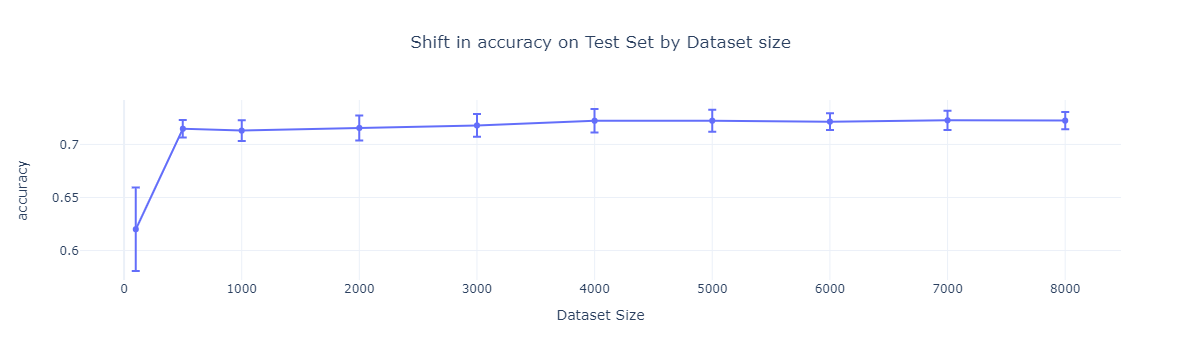

In [353]:
ds1 = agg_stats_all.loc[agg_stats_all['theta']==-0.05][['accuracy_mean','accuracy_std','Dset_sz']]
ds2 = agg_stats_all.loc[agg_stats_all['theta']==0.05][['accuracy_mean','accuracy_std','Dset_sz']]



import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Add traces
fig.add_trace(
    go.Scatter(x=ds1['Dset_sz'], y=ds1['accuracy_mean'], name="CASTLE",         
    error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=ds1['accuracy_std'],
            visible=True)
            ),
    secondary_y=False, 
)

fig.add_trace(
    go.Scatter(x=ds2['Dset_sz'], y=ds2['accuracy_mean'], name="CausalInj",         
    error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=ds2['accuracy_std'],
            visible=True)
            ),
    secondary_y=False, 
)

# Add figure title
fig.update_layout(
    title={
        'text': "Shift in accuracy on Test Set by Dataset size",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend={
        'y':-0.4,
        'x':0.5,
        'orientation':"h",
        'xanchor': 'center',
        'yanchor': 'bottom'},
    template='plotly_white'
    
)

# Set x-axis title
fig.update_xaxes(title_text="Dataset Size")

# Set y-axes titles
fig.update_yaxes(title_text="accuracy", secondary_y=False)
# fig.update_yaxes(title_text="Number of Edges in DAG", secondary_y=True)


fig.show()

In [14]:
pd.qcut(df['0'], q=10, precision=0).value_counts()

(3.9, 15.7]    10000
(3.4, 3.9]     10000
(3.0, 3.4]     10000
(2.7, 3.0]     10000
(2.4, 2.7]     10000
(2.1, 2.4]     10000
(1.8, 2.1]     10000
(1.5, 1.8]     10000
(1.0, 1.5]     10000
(-2.0, 1.0]    10000
Name: 0, dtype: int64

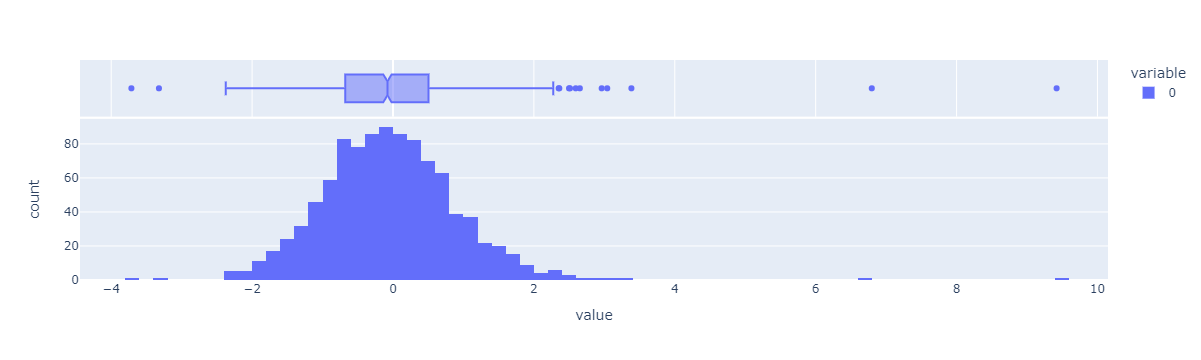

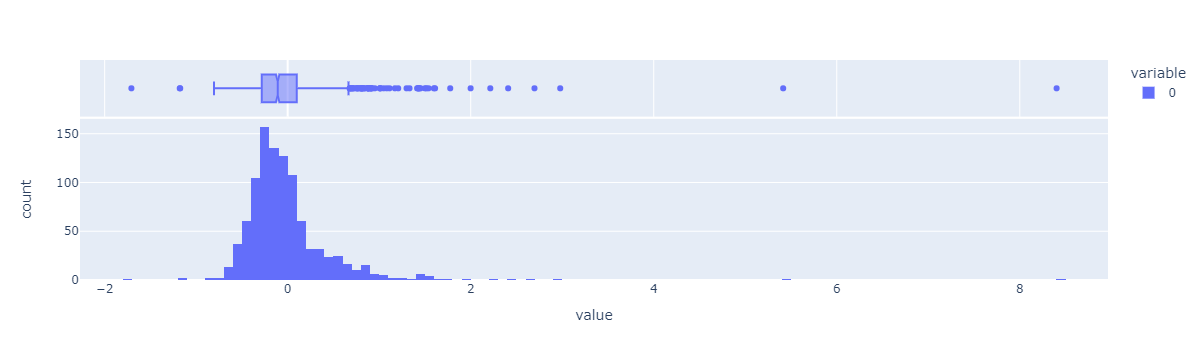

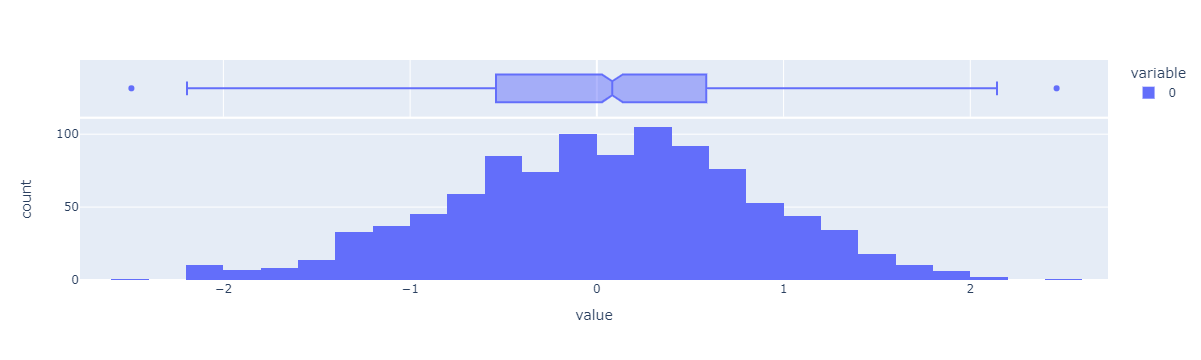

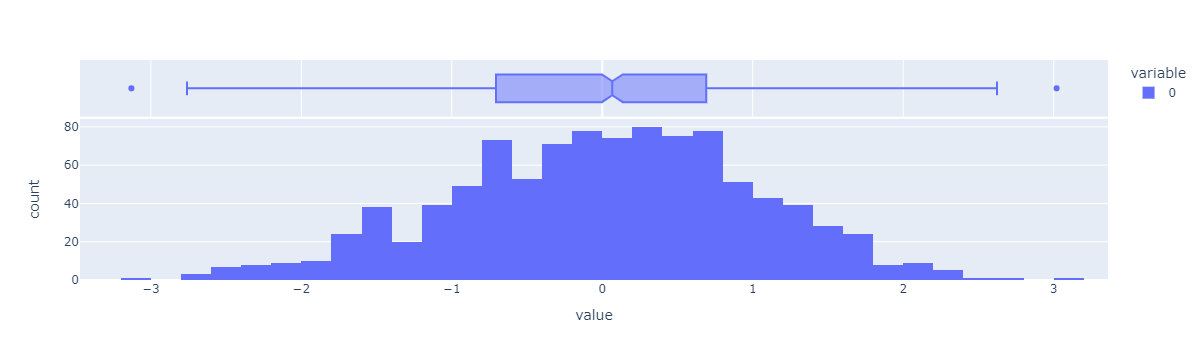

In [50]:
y_hat = castle.pred(X_test)
errors = castle.pred(X_test)-np.expand_dims(y_test , -1)
standard_errors = (errors-errors.mean())/errors.std()

fig = px.histogram(y_test, marginal="box")
fig.show()

fig = px.histogram(y_hat, marginal="box")
fig.show()

# fig = px.histogram(errors, marginal="box")
# fig.show()

fig = px.histogram(standard_errors, marginal="box")
fig.show()

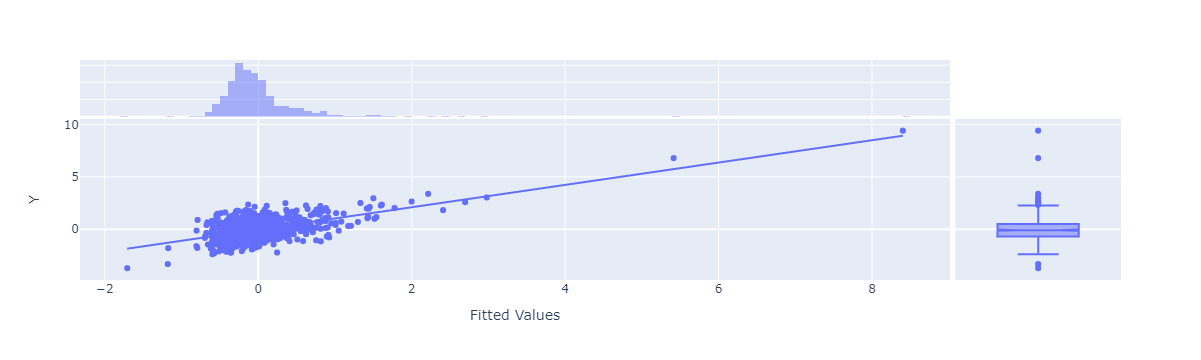

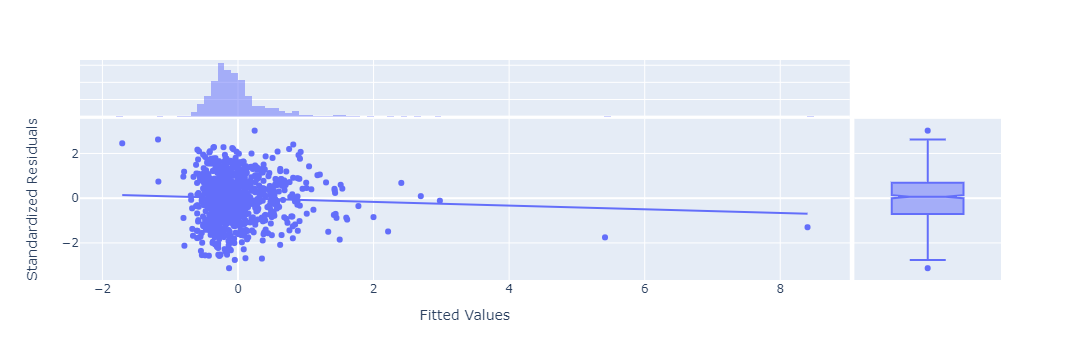

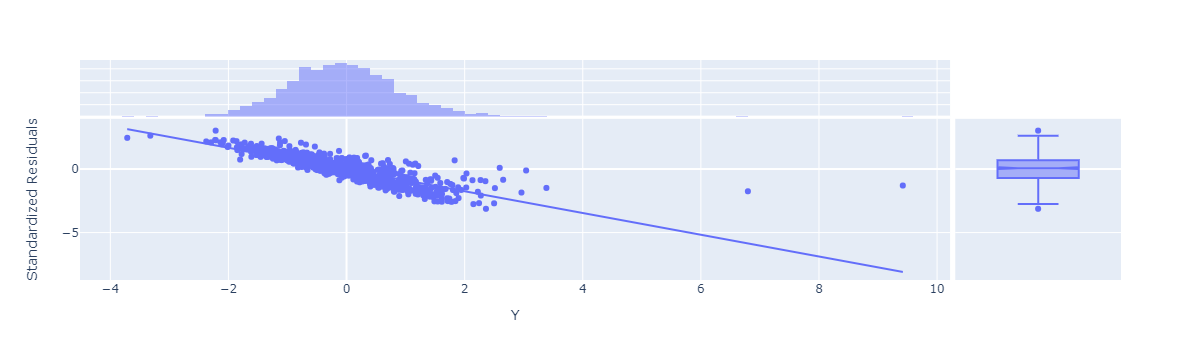

In [62]:
fig = px.scatter(x=castle.pred(X_test).flatten(), y=y_test, marginal_x="histogram", marginal_y="box",
                 trendline="ols",
                    labels={
                     "x": "Fitted Values",
                     "y": "Y"
                    },)
fig.show()

fig = px.scatter(x=castle.pred(X_test).flatten(), y=standard_errors.flatten(), marginal_x="histogram", marginal_y="box",
                 trendline="ols",
                    labels={
                     "x": "Fitted Values",
                     "y": "Standardized Residuals"
                    },)
fig.show()

# fig = px.scatter(x=y_test, y=standard_errors.flatten(), marginal_x="histogram", marginal_y="box",
#                  trendline="ols",
#                     labels={
#                      "x": "Y",
#                      "y": "Standardized Residuals"
#                     },)
# fig.show()

In [19]:
for std in ["accuracy","accuracy_std_1","accuracy_std_2","accuracy_std_3"]:

    version = "fico_size"
#     std = 
    agg_stats_all = pd.DataFrame()
    sizes = [100,500,1000,4000,8000]


    for size in sizes:
        # filename = f"5FoldCASTLE.Reg.Synth.{size}.pkl"
    # for size in [50,100,200,500,1000]:
        filename = f"results/Nested5FoldCASTLE.Reg.Synth.{size}.{version}.pkl"
        describe = load_pickle(os.path.join(filename))

#         display(pd.DataFrame([(describe[c].items()) for c in describe]))
    #     display(pd.DataFrame.from_dict(describe).T)
    #     print([describe.items() for a in describe])


        agg_stats = pd.DataFrame([(describe[c]['theta'],describe[c]['fold'],describe[c][std]) for c in describe]).groupby(0, as_index=False).agg({1 : ['max'], 2 : ['mean', 'std']})
        agg_stats.columns = ['theta', 'folds', 'accuracy_mean', 'accuracy_std']

        agg_stats.loc[agg_stats['theta']==-1,'theta'] = -0.05

        # display(agg_stats)

        n_edges = pd.DataFrame([(theta, nx.from_numpy_matrix(DAG_retreive_np(W_est, theta), create_using=nx.DiGraph, parallel_edges=False).number_of_edges()) for theta in agg_stats['theta']])

        n_edges.loc[n_edges[0]==-1,0] = -0.05
        n_edges.loc[n_edges[0]==-0.05,1] = nx.from_numpy_matrix(W_est, create_using=nx.DiGraph, parallel_edges=False).number_of_edges()

        # display(n_edges)

        n_edges_DAG = n_edges.merge(pd.DataFrame([(theta, nx.is_directed_acyclic_graph(nx.from_numpy_matrix(DAG_retreive_np(W_est, theta), create_using=nx.DiGraph, parallel_edges=False))) for theta in agg_stats['theta']]), on=0)

        n_edges_DAG.columns = ['theta', 'N_edges', 'is_DAG']

        agg_stats.merge(n_edges_DAG,on='theta')
        agg_stats['Dset_sz'] = size

        # display(agg_stats)

        agg_stats_all = pd.concat([agg_stats_all,agg_stats])

    agg_stats_all

    ds = agg_stats_all[['theta', 'accuracy_mean', 'accuracy_std','Dset_sz']]

    ds['values'] = ["{0:.2f}".format(round(mean,2))+" ({0:.2f})".format(round(std,2)) for mean,std in zip(ds['accuracy_mean'],ds['accuracy_std']) ]
    ds.loc[ds['theta']==-0.05,'theta'] = "CASTLE"
    ds.loc[ds['theta']==0.006,'theta'] = "Causal Injected"
    table = ds.pivot(index='Dset_sz',columns='theta', values='values')
    cols = list(table.columns.values)
#     print(cols)

    cols = cols[-1:] + cols[:-1]

    display(table)
    print(table.columns.values)

    def compute_top_2(names):
        t = ''
        pcount = round(len(names)/len(np.unique(names)))
        _, idx = np.unique(names, return_index=True)
        names = names[np.sort(idx)]
#         print(names)
        for i in range(len(names)):
            t += ' & \multicolumn{' + str(pcount) + '}{c}{' + str(names[i]) + '}'
        return t

    top1 = 'Dataset' + compute_top_2(table.columns.values) + '\\\\ \n\hline '

    print_table = lambda table, top : table.to_latex(escape = False, index = True, index_names = False, header =False,
                         formatters=[(lambda x : '\!' + str(x) + '\!') for col in table.columns.values],
    #                      header = [f'\!\!{nice_relations[col[-1:]] if col != "BC" else ""}\!\!' for col in table.columns.values],\
                         column_format = 'r' + 'c' * (len(table.columns.values)),
                        ).replace(r'\toprule', top).replace(r'\midrule', r'\hline').replace(r'\bottomrule', r'\hline').replace('.0%', '%').replace('\!%', '\!0%').replace('%', '\%')

    print(print_table(table, top1))

    ds1 = agg_stats_all.loc[agg_stats_all['theta']==-0.05][['accuracy_mean','accuracy_std','Dset_sz']]
    ds2 = agg_stats_all.loc[agg_stats_all['theta']==0.05][['accuracy_mean','accuracy_std','Dset_sz']]

    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": False}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=ds1['Dset_sz'], y=ds1['accuracy_mean'], name=f"CASTLE",         
        error_y=dict(
                type='data', # value of error bar given in data coordinates
                array=ds1['accuracy_std'],
                visible=True)
                ),
        secondary_y=False, 
    )

    fig.add_trace(
        go.Scatter(x=ds2['Dset_sz'], y=ds2['accuracy_mean'], name=f"CausalInj",         
        error_y=dict(
                type='data', # value of error bar given in data coordinates
                array=ds2['accuracy_std'],
                visible=True)
                ),
        secondary_y=False, 
    )

    # Add figure title
    fig.update_layout(
        title={
            'text': f"Shift in {std} on Test Set by Dataset size",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        legend={
            'y':-0.4,
            'x':0.5,
            'orientation':"h",
            'xanchor': 'center',
            'yanchor': 'bottom'},
        template='plotly_white'

    )

    # Set x-axis title
    fig.update_xaxes(title_text="Dataset Size")

    # Set y-axes titles
    fig.update_yaxes(title_text="accuracy", secondary_y=False)
    # fig.update_yaxes(title_text="Number of Edges in DAG", secondary_y=True)


    fig.show()

Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.100.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.500.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.1000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.4000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.8000.fico_size.pkl


theta         CASTLE Causal Injected
Dset_sz                             
100      0.62 (0.04)     0.67 (0.02)
500      0.71 (0.01)     0.70 (0.01)
1000     0.71 (0.01)     0.71 (0.01)
4000     0.72 (0.01)     0.71 (0.01)
8000     0.72 (0.01)     0.71 (0.01)

['CASTLE' 'Causal Injected']
\begin{tabular}{rcc}
Dataset & \multicolumn{1}{c}{CASTLE} & \multicolumn{1}{c}{Causal Injected}\\ 
\hline 
100  &  \!0.62 (0.04)\! &  \!0.67 (0.02)\! \\
500  &  \!0.71 (0.01)\! &  \!0.70 (0.01)\! \\
1000 &  \!0.71 (0.01)\! &  \!0.71 (0.01)\! \\
4000 &  \!0.72 (0.01)\! &  \!0.71 (0.01)\! \\
8000 &  \!0.72 (0.01)\! &  \!0.71 (0.01)\! \\
\hline
\end{tabular}



Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.100.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.500.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.1000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.4000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.8000.fico_size.pkl


theta       CASTLE Causal Injected
Dset_sz                           
100      nan (nan)       nan (nan)
500      nan (nan)       nan (nan)
1000     nan (nan)       nan (nan)
4000     nan (nan)       nan (nan)
8000     nan (nan)       nan (nan)

['CASTLE' 'Causal Injected']
\begin{tabular}{rcc}
Dataset & \multicolumn{1}{c}{CASTLE} & \multicolumn{1}{c}{Causal Injected}\\ 
\hline 
100  &  \!nan (nan)\! &  \!nan (nan)\! \\
500  &  \!nan (nan)\! &  \!nan (nan)\! \\
1000 &  \!nan (nan)\! &  \!nan (nan)\! \\
4000 &  \!nan (nan)\! &  \!nan (nan)\! \\
8000 &  \!nan (nan)\! &  \!nan (nan)\! \\
\hline
\end{tabular}



Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.100.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.500.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.1000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.4000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.8000.fico_size.pkl


theta       CASTLE Causal Injected
Dset_sz                           
100      nan (nan)       nan (nan)
500      nan (nan)       nan (nan)
1000     nan (nan)       nan (nan)
4000     nan (nan)       nan (nan)
8000     nan (nan)       nan (nan)

['CASTLE' 'Causal Injected']
\begin{tabular}{rcc}
Dataset & \multicolumn{1}{c}{CASTLE} & \multicolumn{1}{c}{Causal Injected}\\ 
\hline 
100  &  \!nan (nan)\! &  \!nan (nan)\! \\
500  &  \!nan (nan)\! &  \!nan (nan)\! \\
1000 &  \!nan (nan)\! &  \!nan (nan)\! \\
4000 &  \!nan (nan)\! &  \!nan (nan)\! \\
8000 &  \!nan (nan)\! &  \!nan (nan)\! \\
\hline
\end{tabular}



Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.100.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.500.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.1000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.4000.fico_size.pkl
Loaded PICKLE from results/Nested5FoldCASTLE.Reg.Synth.8000.fico_size.pkl


theta       CASTLE Causal Injected
Dset_sz                           
100      nan (nan)       nan (nan)
500      nan (nan)       nan (nan)
1000     nan (nan)       nan (nan)
4000     nan (nan)       nan (nan)
8000     nan (nan)       nan (nan)

['CASTLE' 'Causal Injected']
\begin{tabular}{rcc}
Dataset & \multicolumn{1}{c}{CASTLE} & \multicolumn{1}{c}{Causal Injected}\\ 
\hline 
100  &  \!nan (nan)\! &  \!nan (nan)\! \\
500  &  \!nan (nan)\! &  \!nan (nan)\! \\
1000 &  \!nan (nan)\! &  \!nan (nan)\! \\
4000 &  \!nan (nan)\! &  \!nan (nan)\! \\
8000 &  \!nan (nan)\! &  \!nan (nan)\! \\
\hline
\end{tabular}



## Partial DAG completion

In [9]:
loaded_adj = np.array((
[0.0  ,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0],
[1.0  ,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
[1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
[1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0],
[1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0],
[1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0],
[1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0],
[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0],
[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0],
[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0]
))

tau = 0.05
print("tau:",tau)

maxed_adj = DAG_retreive_np(loaded_adj, tau)

heat_mat(maxed_adj)

plot_DAG(maxed_adj, ori_dag=G, graphic_type = "py")

tau: 0.05


Total Number of Edges in G: 88
Max in degree: 9
DAG: False


In [11]:
n_folds=1
if n_folds > 1:
    kf = KFold(n_splits = n_folds, random_state = 1, shuffle = True)

    fold = 0
    REG_castle = []
    print("Dataset limits are", np.ptp(X_DAG), np.ptp(X_test), np.ptp(y_test))
    for train_idx, val_idx in kf.split(X_DAG):
        fold += 1
        print("fold = ", fold)
        print("******* Doing dataset size = ", len(train_idx) , "****************")
        X_train = X_DAG[train_idx]
        y_train = np.expand_dims(X_DAG[train_idx][:,0], -1)
        X_val = X_DAG[val_idx]
        y_val = X_DAG[val_idx][:,0]

        tau = 0.05
        castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                            w_threshold = tau, ckpt_file = ckpt_file
                        )

        num_nodes = np.shape(X_DAG)[1]
        castle.fit(X=X_train, y=y_train, num_nodes=num_nodes, X_val=X_val, y_val=y_val,
                overwrite=False, tune=True, maxed_adj=loaded_adj, tuned=False)

        W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
        heat_mat(W_est)
        REG_castle.append(mean_squared_error(castle.pred(X_test), y_test))
        print("MSE = ", mean_squared_error(castle.pred(X_test), y_test))

        if fold > 1:
            print("MEAN =", np.mean(REG_castle), "STD =", np.std(REG_castle))
            castle.__del__()
else:
        print("******* Doing dataset size = ", dataset_sz , "****************")
        X_train = X_DAG
        y_train = np.expand_dims(X_DAG[:,0], -1)
        X_val = X_test
        y_val = y_test

        w_threshold = 0.3
        castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                            w_threshold = w_threshold, ckpt_file = ckpt_file, seed = seed
                        )

        num_nodes = np.shape(X_DAG)[1]
        castle.fit(X=X_train, y=y_train, num_nodes=num_nodes, X_val=X_val, y_val=y_val,
                overwrite=False, tune=True, maxed_adj=loaded_adj, tuned=False, seed = seed)
        print("MSE = ", mean_squared_error(castle.pred(X_test), y_test))

        W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
        heat_mat(W_est)

******* Doing dataset size =  5000 ****************
Random seed 2021 set for:
INFO:tensorflow:Restoring parameters from tmp.ckpt
Model Loaded from  tmp.ckpt
Begin Tuning - Apply Mask from DAG
Random seed 2021 set for:
Step 1, Loss= 0.7109 h_value: 0.00027942657
Val Loss= 0.6875
Step 2, Loss= 0.7165 h_value: 0.00025177002
Val Loss= 0.6684
Step 3, Loss= 0.7102 h_value: 0.0002632141
Val Loss= 0.6885
Step 4, Loss= 0.7247 h_value: 0.00021266937
Val Loss= 0.6673
Step 5, Loss= 0.7187 h_value: 0.00020980835
Val Loss= 0.6983
Step 6, Loss= 0.7366 h_value: 0.00024032593
Val Loss= 0.7000
Step 7, Loss= 0.7214 h_value: 0.00026130676
Val Loss= 0.6820
Step 8, Loss= 0.7216 h_value: 0.0002632141
Val Loss= 0.6717
Step 9, Loss= 0.7318 h_value: 0.00022029877
Val Loss= 0.6662
Step 10, Loss= 0.7138 h_value: 0.00020217896
Val Loss= 0.7561
Step 11, Loss= 0.7379 h_value: 0.00025844574
Val Loss= 0.6731
Step 12, Loss= 0.7190 h_value: 0.00018978119
Val Loss= 0.6646
Step 13, Loss= 0.7210 h_value: 0.00022888184
Val 

In [36]:
heat_mat(W_est)

maxed_adj = DAG_retreive_np(W_est, 0.012)

heat_mat(maxed_adj)

plot_DAG(W_est, ori_dag=None, graphic_type = "py", names=[a.split('_')[0] for a in df.columns.values])

Total Number of Edges in G: 87
Max in degree: 17
DAG: False


['RiskPerformance',
 'ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades60Ever2DerogPubRec',
 'NumTrades90Ever2DerogPubRec',
 'NumTotalTrades',
 'NumTradesOpeninLast12M',
 'PercentTradesNeverDelq',
 'MSinceMostRecentDelq',
 'MaxDelq2PublicRecLast12M',
 'MaxDelqEver',
 'PercentInstallTrades',
 'NetFractionInstallBurden',
 'NumInstallTradesWBalance',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NumRevolvingTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'PercentTradesWBalance']

### Old stuff

In [10]:
run_full = False
if run_full:
    print("******* Doing dataset size = ", dataset_sz , "****************")
    X_train = X_DAG
    y_train = np.expand_dims(X_DAG[:,0], -1)
    X_val = X_test
    y_val = y_test

    w_threshold = 0.3
    castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                        w_threshold = w_threshold, ckpt_file = ckpt_file
                    )

    num_nodes = np.shape(X_DAG)[1]
    castle.fit(X=X_train, y=y_train, num_nodes=num_nodes, X_val=X_val, y_val=y_val,
            overwrite=False, tune=True, tuned=False, maxed_adj=maxed_adj)

    W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
    heat_mat(W_est)

In [51]:
save_mat = True
if save_mat:
    pd.DataFrame(W_est).to_csv("fico_adj_matrix.csv", index=False)

In [12]:
# necessary when wanting to load different castle consecutively
clean_up = False
if clean_up:
    castle.__del__()

In [6]:
load_hard_mat = True
if load_hard_mat:
    ### To run only if the above code is not run
    intersection_matrix= (
    [0.0,0.002,0.017,0.021,0.005,0.045,0.035,0.007,0.053,0.055],
    [0.008,0.0,0.072,0.061,0.07,0.005,0.011,0.008,0.004,0.007],
    [0.095,0.036,0.0,0.031,0.027,0.139,0.009,0.005,0.011,0.008],
    [0.071,0.04,0.031,0.0,0.035,0.003,0.108,0.109,0.011,0.007],
    [0.013,0.045,0.022,0.027,0.0,0.008,0.011,0.004,0.007,0.005],
    [0.039,0.003,0.022,0.006,0.005,0.0,0.009,0.007,0.003,0.014],
    [0.038,0.004,0.007,0.011,0.007,0.01,0.0,0.023,0.003,0.163],
    [0.024,0.006,0.004,0.01,0.003,0.022,0.028,0.0,0.009,0.009],
    [0.026,0.004,0.006,0.002,0.009,0.004,0.015,0.005,0.0,0.014],
    [0.026,0.004,0.004,0.005,0.004,0.008,0.073,0.004,0.007,0.0]
    )
    # intersection_matrix=pd.DataFrame(intersection_matrix)
    # intersection_matrix=intersection_matrix.to_numpy()
    W_est = np.array(intersection_matrix)

In [9]:
import math
penalty_mis = -1
penalty_add = -1
penalty_dir = -1

n=G.number_of_nodes()
r=2
n_perm = math.factorial(n)/math.factorial(n-r)

print(G.edges())

print(G1.edges())

# import collections
# compare = lambda x, y: collections.Counter(x) == collections.Counter(y)

# compare(G.edges(),G1.edges())

a = set(G.edges())
b = set(G1.edges())

print("Equal sets:",a==b)
print("intersection:",a.intersection(b)   )
print("union:",a.union(b)        )
print("unequal:",a.union(b)  - a.intersection(b))   

print("Missing:",len(a-a.intersection(b)))
print("Added:",len(b-a.intersection(b)))

(n_perm + len(a-a.intersection(b))*penalty_mis + len(b-a.intersection(b))*penalty_add)/n_perm

[(0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (2, 5), (2, 0), (3, 0), (3, 6), (3, 7), (6, 9)]
[(0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (2, 0), (2, 5), (3, 0), (3, 6), (3, 7), (6, 9)]
Equal sets: True
intersection: {(1, 2), (6, 9), (1, 3), (3, 0), (1, 4), (2, 0), (3, 6), (0, 9), (3, 7), (2, 5), (0, 8)}
union: {(6, 9), (1, 3), (3, 0), (1, 4), (3, 7), (2, 5), (0, 8), (1, 2), (2, 0), (3, 6), (0, 9)}
unequal: set()
Missing: 0
Added: 0


1.0